# Predictions

Model: $SARIMA(1,1,0)(0,1,0)_{12}$

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAXResults, SARIMAX
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
theme = 'seaborn-v0_8-dark-palette'
fig_facecolor = "#333333"
ax_facecolor = "#444444"

In [2]:
serie = pd.read_parquet("../Data/processed_series.parquet")
serie = pd.Series(serie["AverageTemperature"], name="AverageTemperature")
serie.index = pd.DatetimeIndex(serie.index)
serie = serie.asfreq("MS")
freq = pd.infer_freq(serie.index)
print(f"Frecuencia inferida: {freq}")
serie.sample(10)

Frecuencia inferida: MS


date
2021-05-01    15.6
2018-05-01    19.7
2019-02-01    -7.9
2024-04-01    10.9
2023-10-01    11.3
2019-08-01    21.6
2022-12-01    -4.5
2021-10-01    12.4
2018-10-01     9.5
2020-04-01     8.9
Name: AverageTemperature, dtype: float64

In [3]:
best_model = SARIMAXResults.load("../Outputs/Models/SARIMA_1-1-0_0-1-0.pkl")
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 AverageTemperature   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -209.288
Date:                            Wed, 25 Jun 2025   AIC                            422.575
Time:                                    18:56:53   BIC                            427.364
Sample:                                02-01-2017   HQIC                           424.496
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3958      0.100     -3.957      0.000      -0.592      -0.200
sigma2        10.2750      1.633      6.292      0.000       7.074      13.476
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.10   Prob(JB):                         0.96
Heteroskedasticity (H):               0.58   Skew:                            -0.05
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
pred = best_model.get_forecast(steps=12)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

pred_df = pd.DataFrame({
    "Forecast": pred.predicted_mean,
    "Lower_CI": conf_int.iloc[:, 0],
    "Upper_CI": conf_int.iloc[:, 1]
})
pred_df.to_parquet("../Outputs/Predictions/predictions_12_months.parquet")

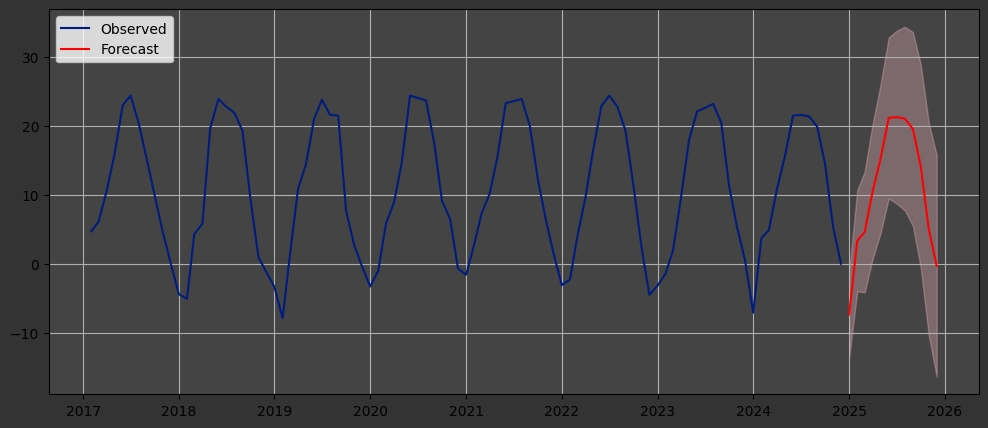

<Figure size 640x480 with 0 Axes>

In [5]:
with plt.style.context(theme):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(serie, label="Observed")
    ax.plot(pred_mean, label="Forecast", color="red")
    ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    ax.set_facecolor(ax_facecolor)
    fig.patch.set_facecolor(fig_facecolor)
    ax.legend()
    ax.grid()
    plt.show()
    plt.savefig("../Outputs/Predictions/prediction_plot.png", facecolor=fig_facecolor)

In [7]:
order = (1, 1, 0)
seasonal_order = (0, 1, 0, 12)

fig, ax = plt.subplots(figsize=(12, 5))
line_train, = ax.plot([], [], label="Train", color="cyan")
line_pred, = ax.plot([], [], label="Prediction", color="red", linestyle="--")
title = ax.set_title("", color="white")
ax.set_facecolor(ax_facecolor)
fig.patch.set_facecolor(fig_facecolor)
ax.tick_params(colors="white")
ax.legend(facecolor=ax_facecolor, edgecolor="white", labelcolor="white")
ax.grid(True, linestyle="--", alpha=0.5)

def init():
    ax.set_xlim(serie.index[0], serie.index[-1])
    ax.set_ylim(serie.min() - 1, serie.max() + 1)
    line_train.set_data([], [])
    line_pred.set_data([], [])
    title.set_text("")
    return line_train, line_pred, title

def update(frame):
    if frame < 24:
        return line_train, line_pred, title

    train_series = serie.iloc[:frame]
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast_steps = 12
    pred = result.get_forecast(steps=forecast_steps)
    pred_index = pd.date_range(start=train_series.index[-1] + pd.DateOffset(months=1),
                               periods=forecast_steps, freq="MS")
    
    line_train.set_data(serie.index[:frame], serie.values[:frame])
    line_pred.set_data(pred_index, pred.predicted_mean)

    if frame == len(serie) - 1:
        title.set_text("✨ Forecast Complete! The future is now. 🌤️")
    else:
        title.set_text(f"Training to: {train_series.index[-1].date()}\nNext {forecast_steps} Months Predictions")
    
    return line_train, line_pred, title

    

anim = FuncAnimation(fig, update, frames=np.arange(24, len(serie)), init_func=init,
                     blit=False, interval=300)

anim.save("../Outputs/Predictions/animated_prediction.gif", writer="pillow")